In [4]:
# --- Scraper + Analysis Script ---
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# West North Central
(I'll be honest, I've just been updating the zips and locations as needed. instead of copy-pasting the same code in several places.)

In [52]:
# --- Product Data ---
products = [
    ("Bananas", "https://www.target.com/p/organic-bananas-2lb-good-38-gather-8482/-/A-85759852#lnk=sametab"),
    ("Vegetable Oil", "https://www.target.com/p/vegetable-oil-good-gather/-/A-89467834?preselect=78376315#lnk=sametab"),
    ("Gum", "https://www.target.com/p/extra-spearmint-sugarfree-gum-15ct/-/A-13307857#lnk=sametab"),
    ("Toilet Paper", "https://www.target.com/p/cottonelle-ultra-comfort-toilet-paper/-/A-54605704?preselect=75665830#lnk=sametab"),
    ("AirPods", "https://www.target.com/p/apple-airpods-4/-/A-93606140?preselect=85978618#lnk=sametab"),
    ("Cotton Swabs", "https://www.target.com/p/q-tips-cotton-swabs-375ct/-/A-11223546#lnk=sametab"),
    ("Diapers", "https://www.target.com/p/pampers-swaddlers-active-baby-diapers-select-size-and-count/-/A-14783999?preselect=53461432#lnk=sametab"),
    ("T-Shirt", "https://www.target.com/p/women-s-linen-short-sleeve-t-shirt-universal-thread/-/A-93711326?preselect=92878440#lnk=sametab"),
    ("Eggs", "https://www.target.com/p/grade-a-large-eggs-12ct-good-38-gather-8482-packaging-may-vary/-/A-14713534#lnk=sametab"),
    ("Shampoo", "https://www.target.com/p/native-coconut-vanilla-moisturizing-shampoo/-/A-94666723?preselect=80120273#lnk=sametab"),
    ("Milk", "https://www.target.com/p/milk-good-gather/-/A-94602358?preselect=13276134#lnk=sametab")
]

#       rural, suburban, urban
zips = ['50702', '50009', '52404',
        '67401', '66062', '66111',
        '56601', '55066', '55403',
        '63010', '63033', '64114',
        '68073', '68123', '68116',
        '58563', '58701', '58103',
        '57701', '57401', '57110']

location = ['Waterloo, IA', 'Altoona, IA', 'Cedar Rapids, IA',
            'Salina, KS', 'Olathe, KS', 'Kansas City, KS',
            'Bemidji, MN', 'Red Wing, MN', 'Minneapolis, MN',
            'Arnold, MO', 'Florissant, MO', 'Kansas City, MO',
            'Yutan, NE', 'Bellevue, NE', 'Omaha, NE',
            'New Salem, ND', 'Minot, ND', 'Fargo, ND',
            'Rapid City, SD', 'Aberdeen, SD', 'Sioux Falls, SD']

city_town = ['Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban'] 


combined_data = []

# --- Setup Driver ---
def setup_driver():
    options = Options()
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--window-size=1920x1080")
    driver = webdriver.Firefox(options=options)
    driver.set_page_load_timeout(30)
    return driver

def close_modal(driver):
    try:
        WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "styles_overlay__3ZDC1"))
        )
        close_btn = driver.find_element(By.CLASS_NAME, "styles_overlay__3ZDC1")
        driver.execute_script("arguments[0].click();", close_btn)
        time.sleep(2)
    except:
        pass

# --- Scraping Loop ---
for product_name, url in products:
    print(f"📦 Scraping {product_name}...")
    driver = setup_driver()
    try:
        driver.get(url)
        time.sleep(5)
        close_modal(driver)

        price_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//span[contains(@data-test, 'product-price')]"))
        )
        price = price_element.text
        #combined_data.append({"Product": product_name, "Zip Code": zips[0], "Price": price})
        print(f"✅ Zip Code: {zips} , Price: {price}")
        time.sleep(2)

        for zip_code in zips:
            try:
                time.sleep(2)
                
                edit_buttons = driver.find_elements(By.XPATH, '//*[@id="web-store-id-msg-btn"]/div/div[2]/span')
                time.sleep(3)
                if not edit_buttons:
                    print(f"❌ Could not find 'Edit your location' for zip {zip_code}")
                    continue
                edit_buttons[0].click()
                time.sleep(1)
                zip_input = driver.find_element(By.XPATH, '//*[@id="zip-or-city-state"]')
                zip_input.send_keys(Keys.COMMAND + "a")
                zip_input.send_keys(Keys.BACKSPACE)
                zip_input.send_keys(zip_code)
                time.sleep(1)
                
                print("Clicking the button to update zip")
                
                lookup = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[2]/div[1]/div/div[1]/div[2]/button")
                lookup.click()
                time.sleep(3)
                
                first_available_store = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[2]/div[2]/fieldset/div[1]/div/div[1]/label")
                first_available_store.click()
                time.sleep(1)
                
                shop_this_store = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[3]/button")
                shop_this_store.click()
                time.sleep(3)
                
                price_element = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, "//span[contains(@data-test, 'product-price')]"))
                )
                price = price_element.text
                combined_data.append({"Product": product_name, "Zip Code": zip_code, "Price": price})
                print(f"✅ Zip Code: {zip_code} , Price: {price}")

            except Exception as e:
                print(f"❌ Error processing zip {zip_code}: {e}")
    except Exception as e:
        print(f"❌ Error on main product for {product_name}: {e}")
    finally:
        driver.quit()

📦 Scraping Bananas...
✅ Zip Code: ['50702', '50009', '52404', '67401', '66062', '66111', '56601', '55066', '55403', '63010', '63033', '64114', '68073', '68123', '68116', '58563', '58701', '58103', '57701', '57401', '57110'] , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 50702 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 50009 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 52404 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 67401 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 66062 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 66111 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 56601 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 55066 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 55403 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 63010 , Price: $1.99
Clicking the button to update zip
✅ Zip Code: 63033 , Price: $1.99
Clicking the button to u

✅ Zip Code: 57401 , Price: $179.99
Clicking the button to update zip
✅ Zip Code: 57110 , Price: $179.99
📦 Scraping Cotton Swabs...
✅ Zip Code: ['50702', '50009', '52404', '67401', '66062', '66111', '56601', '55066', '55403', '63010', '63033', '64114', '68073', '68123', '68116', '58563', '58701', '58103', '57701', '57401', '57110'] , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 50702 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 50009 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 52404 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 67401 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 66062 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 66111 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 56601 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 55066 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 55403 , Price: $3.39
Clicking the button to update zip
✅ Zip Code: 630

❌ Error processing zip 55066: Message: Element <span class="sc-b6dbaa40-7 vKRND"> is not clickable at point (229,25) because another element <h2 class="styles_ndsHeading__HcGpD styles_fontSize2__8Iex_ styles_x2Margin__M5gHh styles_heading__lrDgr"> obscures it
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:199:5
ElementClickInterceptedError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:351:5
webdriverClickElement@chrome://remote/content/marionette/interaction.sys.mjs:177:11
interaction.clickElement@chrome://remote/content/marionette/interaction.sys.mjs:136:11
clickElement@chrome://remote/content/marionette/actors/MarionetteCommandsChild.sys.mjs:354:29
receiveMessage@chrome://remote/content/marionette/actors/MarionetteCommandsChild.sys.mjs:230:31

❌ Error processing zip 55403: Message: Element <span class="sc-b6dbaa40-7 vKRND"> is not clickable at point (229,25) because anothe

❌ Error processing zip 58103: Message: Element <span class="sc-b6dbaa40-7 vKRND"> is not clickable at point (229,25) because another element <h2 class="styles_ndsHeading__HcGpD styles_fontSize2__8Iex_ styles_x2Margin__M5gHh styles_heading__lrDgr"> obscures it
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:199:5
ElementClickInterceptedError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:351:5
webdriverClickElement@chrome://remote/content/marionette/interaction.sys.mjs:177:11
interaction.clickElement@chrome://remote/content/marionette/interaction.sys.mjs:136:11
clickElement@chrome://remote/content/marionette/actors/MarionetteCommandsChild.sys.mjs:354:29
receiveMessage@chrome://remote/content/marionette/actors/MarionetteCommandsChild.sys.mjs:230:31

❌ Error processing zip 57701: Message: Element <span class="sc-b6dbaa40-7 vKRND"> is not clickable at point (229,25) because anothe

KeyboardInterrupt: 

,Product,Zip Code,Price
0,Bananas,19931,$1.99
1,Bananas,19901,$1.99
2,Bananas,19808,$1.99
3,Bananas,33403,$1.99
4,Bananas,33463,$1.99
...,...,...,...
259,Milk,24151,$3.89
260,Milk,22305,$3.79
261,Milk,25526,$3.99
262,Milk,26059,$3.99


✅ All product data saved to target_prices_combined.csv


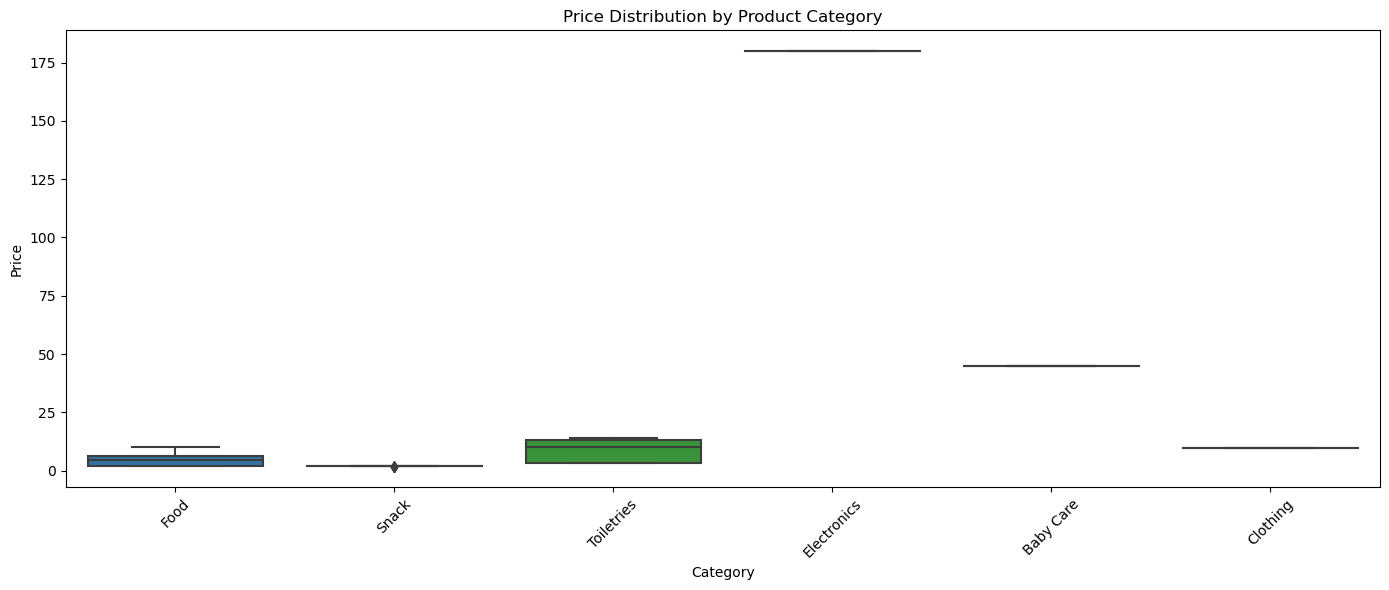


📊 Average Price by Product and ZIP Code:

Zip Code        19808   19901   19931   21009   21030   21704   22305   24151  \
Product                                                                         
AirPods        179.99  179.99  179.99  179.99  179.99  179.99  179.99  179.99   
Bananas          1.99    1.99    1.99    1.99    1.99    1.99    1.99    1.99   
Cotton Swabs     3.39    3.39    3.39    3.39    3.39    3.39    3.39    3.39   
Diapers         44.99   44.99   44.99   44.99   44.99   44.99   44.99   44.99   
Eggs             4.99    4.99    4.99    4.99    4.99    4.99    5.19    4.99   
Gum              1.69    1.69    1.69    1.79    1.79    1.69    1.89    1.79   
Milk             2.99    2.49    2.49    2.49    2.49    2.49    3.79    3.89   
Shampoo          9.99    9.99    9.99    9.99    9.99    9.99    9.99    9.99   
T-Shirt          9.60    9.60    9.60    9.60    9.60    9.60    9.60    9.60   
Toilet Paper    12.99   12.99   12.99   12.99   12.99   12.99   13

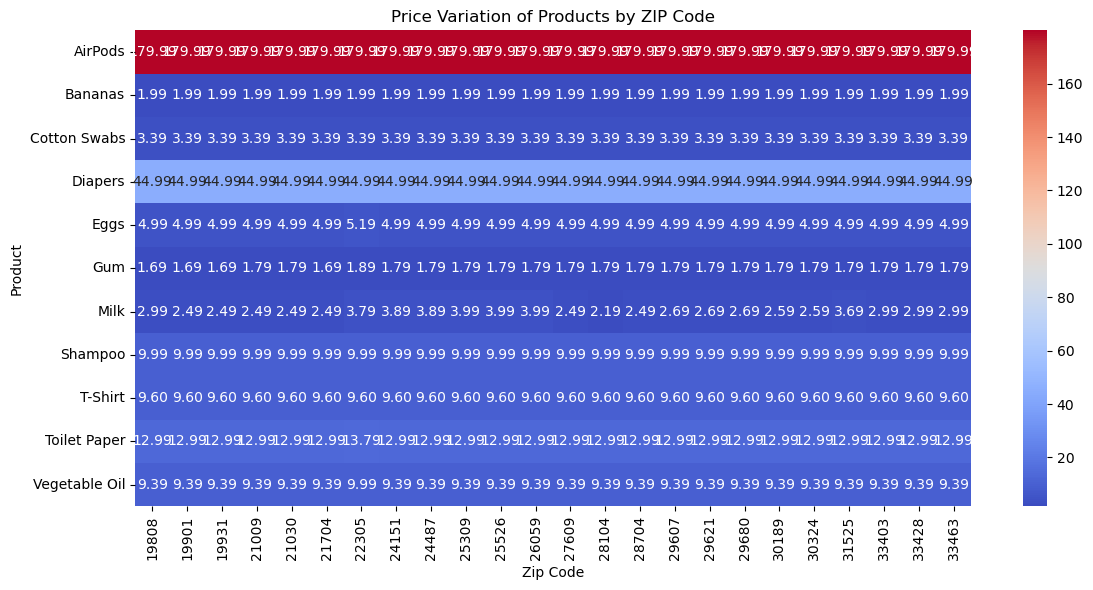

In [51]:
# Updated! This cleans up the data and saves to to a csv, alongside printing the statistics.
# --- Data Cleanup ---
df = pd.DataFrame(combined_data)
display(df)
zip_map = dict(zip(zips, zip(location, city_town)))
df['Location'] = df['Zip Code'].map(lambda z: zip_map.get(z, ["", ""])[0])
df['Area Type'] = df['Zip Code'].map(lambda z: zip_map.get(z, ["", ""])[1])
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# --- Category Mapping ---
category_map = {
    "Bananas": "Food", "Vegetable Oil": "Food", "Gum": "Snack", "Toilet Paper": "Toiletries",
    "AirPods": "Electronics", "Cotton Swabs": "Toiletries", "Diapers": "Baby Care",
    "T-Shirt": "Clothing", "Eggs": "Food", "Shampoo": "Toiletries", "Milk": "Food"
}
df["Category"] = df["Product"].map(category_map)

df.to_csv("target_prices_combined.csv", index=False)
print("✅ All product data saved to target_prices_combined.csv")

# --- EDA + Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Category", y="Price")
plt.title("Price Distribution by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index="Product", columns="Zip Code", values="Price", aggfunc='mean')
print("\n📊 Average Price by Product and ZIP Code:\n")
print(pivot)

print("\n📉 Product Price Variability (Standard Deviation):\n")
print(df.groupby("Product")["Price"].std())

# Linear Regression: Area Type → Price
df_reg = df.copy()
df_reg['Area Code'] = df_reg['Area Type'].map({'Suburban': 0, 'City': 1, 'Urban': 2})
df_reg = df_reg.dropna(subset=['Area Code'])

X = sm.add_constant(df_reg['Area Code'])
y = df_reg['Price']
model = sm.OLS(y, X).fit()
print("\n📈 Linear Regression Summary (Area Code → Price):\n")
print(model.summary())

# K-Means Clustering
pivot_df = df.pivot_table(index="Zip Code", columns="Product", values="Price")
pivot_df = pivot_df.dropna()
if pivot_df.shape[0] >= 2:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pivot_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    pivot_df['Cluster'] = kmeans.fit_predict(scaled)
    print("\n ZIP Code Clusters:\n")
    print(pivot_df['Cluster'])
else:
    print("\n Not enough ZIP Codes with full product prices to perform clustering.")

# Group Means
print("\n🏙️ Average Price by Area Type:\n")
print(df.groupby(['Area Type'])['Price'].mean())

print("\n📊 Average Price by Category and Area Type:\n")
print(df.groupby(['Category', 'Area Type'])['Price'].mean().unstack())

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Price Variation of Products by ZIP Code")
plt.tight_layout()
plt.show()


# In[ ]:

,Product,Zip Code,Price,Location,Area Type,Category
0,Bananas,85748,1.99,"Tuscon, AZ",Rural,Food
1,Bananas,85748,1.99,"Tuscon, AZ",Rural,Food
2,Bananas,79707,1.99,"Midland, TX",Suburban,Food
3,Bananas,85207,1.99,"Mesa, AZ",Urban,Food
4,Bananas,81401,1.99,"Montrose, CO",Rural,Food
...,...,...,...,...,...,...
270,Milk,84095,3.19,"South Jordan, UT",Suburban,Food
271,Milk,84121,3.19,"Salt Lake City, UT",Urban,Food
272,Milk,82609,3.89,"Casper, WY",Rural,Food
273,Milk,83001,4.39,"Jackson, WY",Suburban,Food


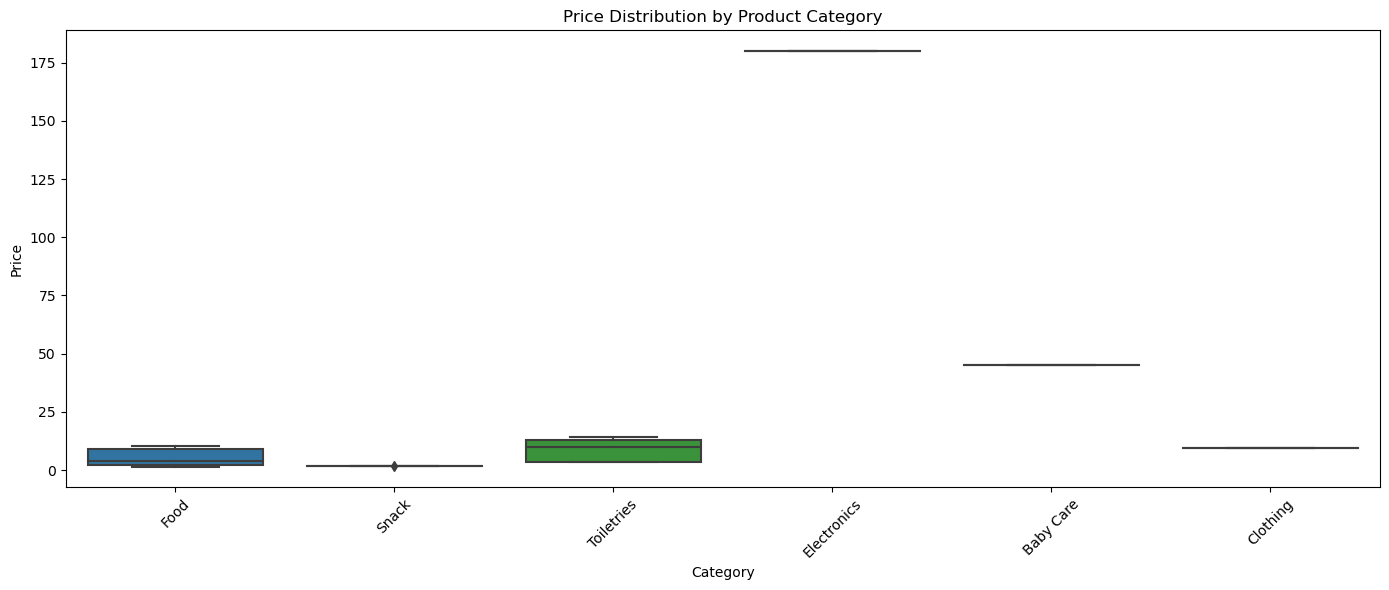


📊 Average Price by Product and ZIP Code:

Zip Code        59718   59901   79707   80108   80202   81401   82009   82609  \
Product                                                                         
AirPods        179.99  179.99  179.99  179.99  179.99  179.99  179.99  179.99   
Bananas          1.99    1.99    1.99    1.99    2.19    1.99    1.99    1.99   
Cotton Swabs     3.39    3.39    3.39    3.39    3.49    3.39    3.39    3.39   
Diapers         44.99   44.99   44.99   44.99   44.99   44.99   44.99   44.99   
Eggs             4.99    4.99    3.99    4.99    5.29    4.49    4.99    4.99   
Gum              1.79    1.79    1.79    1.79    1.79    1.79    1.79    1.79   
Milk             3.59    3.79    3.39    3.59    3.79    3.89    3.79    3.89   
Shampoo          9.99    9.99    9.99    9.99   10.59    9.99    9.99    9.99   
T-Shirt          9.60    9.60    9.60    9.60    9.60    9.60    9.60    9.60   
Toilet Paper    12.99   12.99   12.99   12.99   13.79   12.99   12

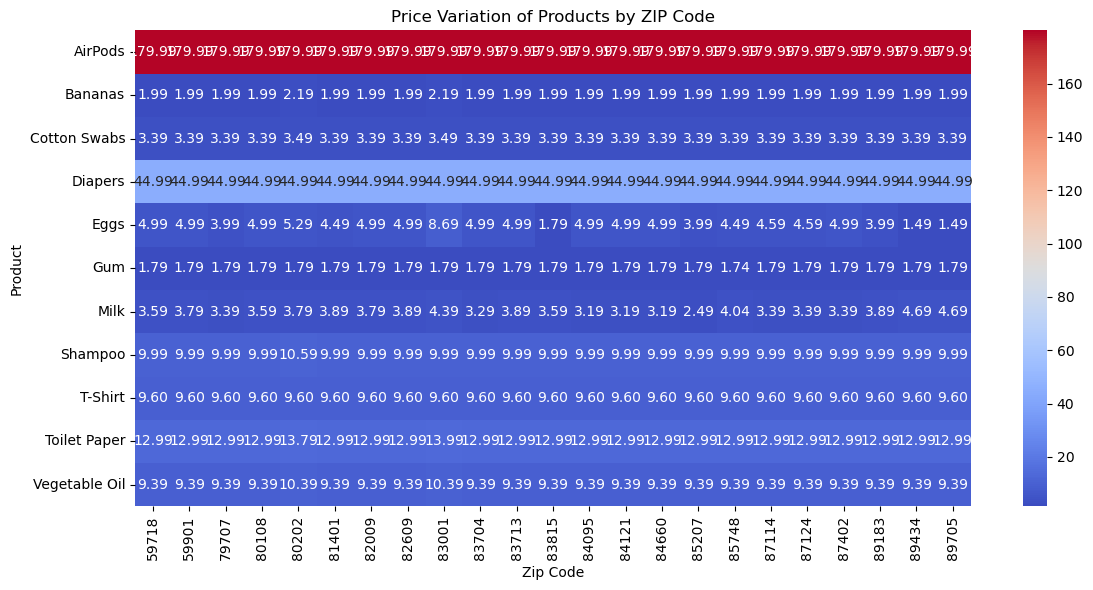

In [39]:
# This version of the code just displays the statistics, importing from a csv so we don't have to re-run the scrapes.
# --- Data Cleanup ---
df = pd.read_csv("target_prices_combined_mountain.csv")
display(df)

# --- Category Mapping ---
category_map = {
    "Bananas": "Food", "Vegetable Oil": "Food", "Gum": "Snack", "Toilet Paper": "Toiletries",
    "AirPods": "Electronics", "Cotton Swabs": "Toiletries", "Diapers": "Baby Care",
    "T-Shirt": "Clothing", "Eggs": "Food", "Shampoo": "Toiletries", "Milk": "Food"
}
df["Category"] = df["Product"].map(category_map)


# --- EDA + Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Category", y="Price")
plt.title("Price Distribution by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index="Product", columns="Zip Code", values="Price", aggfunc='mean')
print("\n📊 Average Price by Product and ZIP Code:\n")
print(pivot)

print("\n📉 Product Price Variability (Standard Deviation):\n")
print(df.groupby("Product")["Price"].std())

# Linear Regression: Area Type → Price
df_reg = df.copy()
df_reg['Area Code'] = df_reg['Area Type'].map({'Suburban': 0, 'City': 1, 'Urban': 2})
df_reg = df_reg.dropna(subset=['Area Code'])

X = sm.add_constant(df_reg['Area Code'])
y = df_reg['Price']
model = sm.OLS(y, X).fit()
print("\n📈 Linear Regression Summary (Area Code → Price):\n")
print(model.summary())

# K-Means Clustering
pivot_df = df.pivot_table(index="Zip Code", columns="Product", values="Price")
pivot_df = pivot_df.dropna()
if pivot_df.shape[0] >= 2:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pivot_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    pivot_df['Cluster'] = kmeans.fit_predict(scaled)
    print("\n ZIP Code Clusters:\n")
    print(pivot_df['Cluster'])
else:
    print("\n Not enough ZIP Codes with full product prices to perform clustering.")

# Group Means
print("\n🏙️ Average Price by Area Type:\n")
print(df.groupby(['Area Type'])['Price'].mean())

print("\n📊 Average Price by Category and Area Type:\n")
print(df.groupby(['Category', 'Area Type'])['Price'].mean().unstack())

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Price Variation of Products by ZIP Code")
plt.tight_layout()
plt.show()
